# 🗳 Udine municipal elections 2023

On the 2<sup>nd</sup> and 3<sup>rd</sup> of April 2023, the five-year local municipal election took place in my hometown [Udine](https://it.wikipedia.org/wiki/Udine).\
This is an excellent opportunity to practice some data analysis, since results data are publicly accessible [on the web service](https://elezioni.regione.fvg.it/consultazioni/ELZ_COM/2023-04-02/udine) provided by the Friuli-Venezia Giulia region.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from pywaffle import Waffle
from matplotlib.colors import rgb2hex

import urllib.request, json 
from pprint import pprint

with urllib.request.urlopen("https://elezioni.regione.fvg.it/distribuzione/json/2023-04-02_ELZ_COM_232_affluenza.json") as url:
    affluenza = json.load(url)[1]

with urllib.request.urlopen("https://elezioni.regione.fvg.it/distribuzione/json/2023-04-02_ELZ_COM_232_sindaci_AMMESSA.json") as url:
    sindaci = json.load(url)

with urllib.request.urlopen("https://elezioni.regione.fvg.it/distribuzione/json/2023-04-02_ELZ_COM_232_voti_sindaco.json") as url:
    sindaci_voto = json.load(url)

with urllib.request.urlopen("https://elezioni.regione.fvg.it/distribuzione/json/2023-04-02_ELZ_COM_232_liste.json") as url:
    liste = json.load(url)

with urllib.request.urlopen("https://elezioni.regione.fvg.it/distribuzione/json/2023-04-02_ELZ_COM_232_voti_liste.json") as url:
    liste_voto = json.load(url)

with urllib.request.urlopen("https://elezioni.regione.fvg.it/distribuzione/json/2023-04-02_ELZ_COM_232_preferenze.json") as url:
    preferenze = json.load(url)
    
sindaci_voti = pd.merge(
    pd.DataFrame.from_dict(sindaci),
    pd.DataFrame.from_dict(sindaci_voto),
    left_on='id',
    right_on='id_candidato',
    suffixes=('_sindaco', '_sindacovoto')
)[['nominativo_sindaco', 'id', 'id_aggregazione', 'id_struttura', 'id_candidato', 'id_aggregazione_candidatura', 'voti_validi']]

liste_voti = pd.merge(
    pd.DataFrame.from_dict(liste),
    pd.DataFrame.from_dict(liste_voto),
    left_on='id',
    right_on='id_candidatura',
    suffixes=('_lista', '_listavoto')
)[['nome_lista', 'id', 'id_padre', 'voti_validi']]

liste_voti = pd.concat([
    liste_voti, 
    pd.DataFrame.from_dict([
        {"nome_lista":"Senza lista (De Toni)", "id_padre":42948, "voti_validi":3547}, # De Toni
        {"nome_lista":"Senza lista (Marchiol)", "id_padre":43424, "voti_validi":1359}, # Marchiol
        {"nome_lista":"Senza lista (Fontanini)", "id_padre":42124, "voti_validi":3565}, # Fontanini
        {"nome_lista":"Senza lista (Salme')", "id_padre":41982, "voti_validi":401}  # Salme'
    
    ]),
    ]).reset_index(drop=True)

sindaci_liste_voti = pd.merge(
    sindaci_voti,
    liste_voti,
    left_on='id_aggregazione',
    right_on='id_padre',
    suffixes=('_sindaco', '_lista')
)[['nominativo_sindaco','voti_validi_sindaco', 'nome_lista','voti_validi_lista']].groupby(['nominativo_sindaco','voti_validi_sindaco','nome_lista']).sum()

voti_totali = sindaci_voti.voti_validi.sum()
voti_totali_liste = voti_totali - (3547+1359+3565+401)

sindaci_voti['voti_percentuale'] = sindaci_voti.voti_validi / voti_totali * 100
sindaci_voti = sindaci_voti[['nominativo_sindaco', 'voti_validi', 'voti_percentuale']].groupby(['nominativo_sindaco', 'voti_percentuale']).sum()

## Turnout

The first statistic that immediately comes to the eye is that of (low) turnout.\
Of the 80,650 total possible voters, only 43,499 (53.94%) went to the polls on the two voting days.\
In addition, a slight superiority of female voters over male voters can be noted.

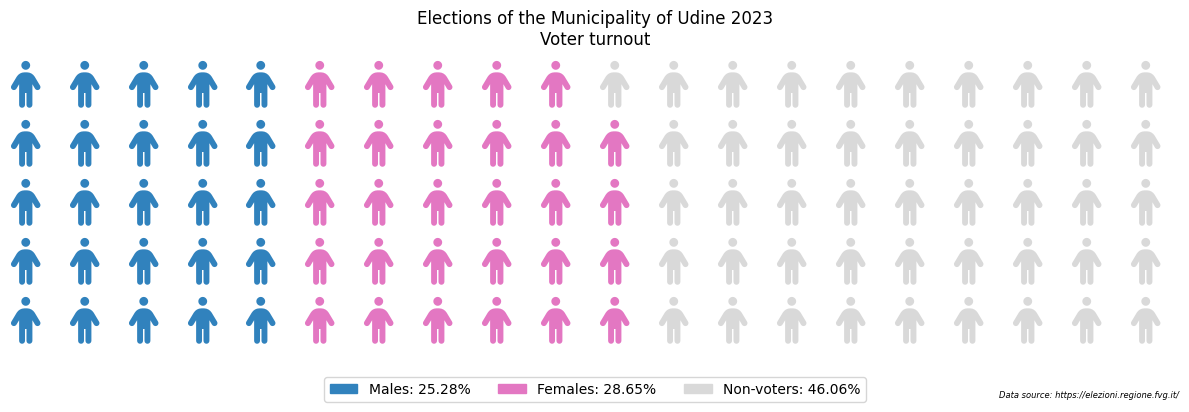

In [3]:
cmap1 = plt.get_cmap("tab20")
cmap2 = plt.get_cmap("tab20c")

plt.figure(
    FigureClass=Waffle, figsize=(12,6), rows=5, columns = 20,
    values=[affluenza['numero_votanti_maschi'], affluenza['numero_votanti_femmine'], affluenza['numero_elettori']-affluenza['numero_votanti_totale']],
    labels = [f"Males: {affluenza['numero_votanti_maschi'] / affluenza['numero_elettori'] * 100:.2f}%", f"Females: {affluenza['numero_votanti_femmine'] / affluenza['numero_elettori'] * 100:.2f}%", f"Non-voters: {(affluenza['numero_elettori']-affluenza['numero_votanti_totale']) / affluenza['numero_elettori'] * 100:.2f}%"],
    icons = 'person',
    colors = [rgb2hex(cmap2(0)), rgb2hex(cmap1(12)), rgb2hex(cmap2(19))],
    font_size='34',
    legend={'loc':'lower center', 'bbox_to_anchor': (0.5, -.25),
            'ncol':3, 'fontsize':10}
)

plt.title('Elections of the Municipality of Udine 2023\nVoter turnout')

plt.text(4.1, -.2, "Data source: https://elezioni.regione.fvg.it/", ha='right', va='center', style='italic', size=6);

plt.show()

This is a widespread trend nationwide, as demonstrated by the CISE (Centro Italiano Studi Elettorali) [on this article](https://cise.luiss.it/cise/2022/09/27/fuga-dalle-urne-affluenza-mai-cosi-bassa-nella-storia-della-repubblica/).\
Political forces, regardless of political position, will have to question themselves with respect to this fact, and implement actions to bring citizens closer to political life.

## Voting results

We come, then, to the voting results.\
What was voted for is the renewal of the city council, and the election of the new mayor. In order to be elected, a candidate must obtain an absolute majority of the votes (50% of votes +1). This means that, since as we have seen a total of 43,499 people voted, a candidate must obtain at least 21,750 votes to be elected as mayor.\
Four challengers competed for that office:

* **Alberto Felice De Toni**, supported by the lists "Partito Democratico", "De Toni Sindaco", "Alleanza Verdi e Sinistra" and "Azione - Italia Viva - Renew Europe";
* **Ivano Marchiol**, supported by the lists "Movimento 5 Stelle", "Spazio Udine - Ivano Marchiol sindaco" and "Udine Città Futura";
* **Pietro Fontanini**, supported by the lists "Forza Italia", "Fratelli D'Italia con Giorgia Meloni", "Identità Civica", "Lega FVG per Salvini Premier", "Lista Civica Fontanini Sindaco" and "Unione di Centro";
* and **Stefano Salmè**, only supported by the "Liberi Elettori - Io amo Udine" list.

Voting allowed for one mayor, one mayor and one list associate, or one mayor, one list associate and a maximum of two preferences (of opposite sex).

The results are shown in the following image:

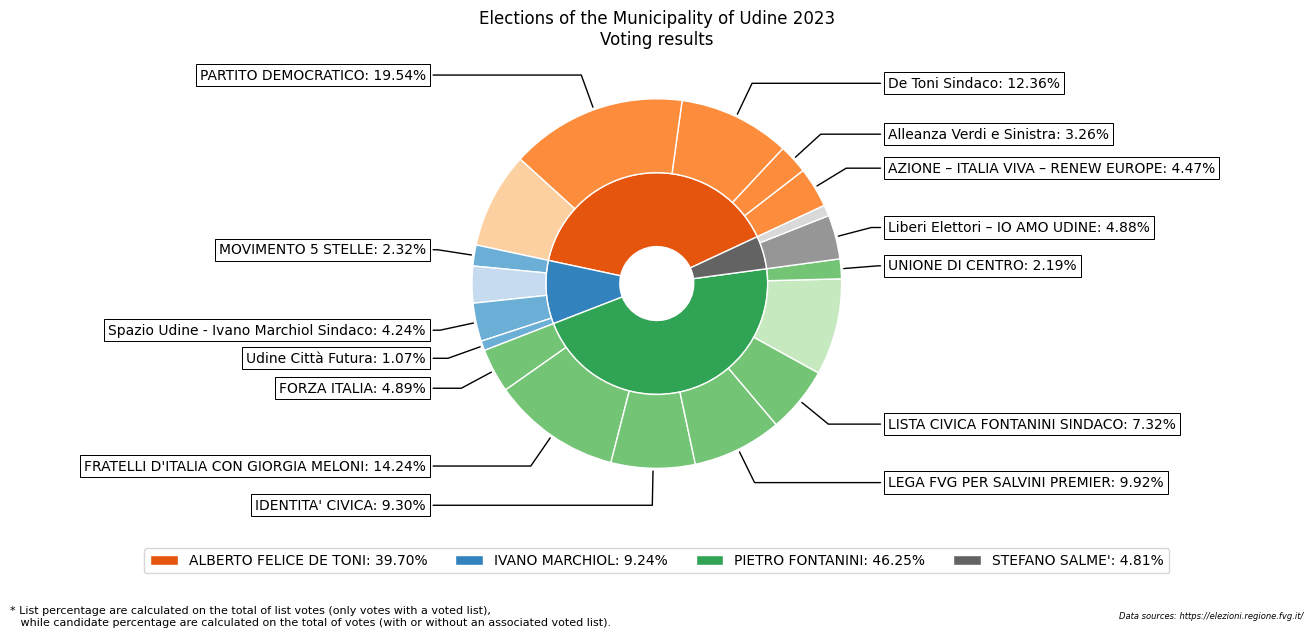

In [4]:
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw=dict(aspect="equal"))

size = 0.4

cmap = plt.get_cmap("tab20c")
inner_colors = cmap([5,5,5,5,7,1,3,1,1,9,9,9,9,9,11,9,17,19])
outer_colors = cmap([4,0,8,16])

wedges, texts = ax.pie(sindaci_voti.voti_validi, radius=1-size, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=25)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=1, va="center")

plt.legend(
    wedges,
    [f"{sindaci_voti.index[i][0]}: {sindaci_voti.index[i][1]:.2f}%" for i in range(len(sindaci_voti))],
    ncol=len(sindaci_voti.index), bbox_to_anchor=[.5, -.1], loc='center'
)

wedges, texts = ax.pie(sindaci_liste_voti.voti_validi_lista, radius=1, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), startangle=25)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    if "Senza lista" not in sindaci_liste_voti.index[i][2]:
        ax.annotate(f"{sindaci_liste_voti.index[i][2]}: {sindaci_liste_voti.values[i][0]/voti_totali_liste*100:.2f}%", xy=(x, y), xytext=(1.25*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set(aspect="equal", title='Elections of the Municipality of Udine 2023\nVoting results')

plt.text(3.5, -1.8, "Data sources: https://elezioni.regione.fvg.it/", ha='right', va='center', style='italic', size=6);

plt.text(-3.5, -1.8, "* List percentage are calculated on the total of list votes (only votes with a voted list),\n   while candidate percentage are calculated on the total of votes (with or without an associated voted list).", ha='left', va='center', size=8);

plt.show()

As you can immediately see, none of the four candidates got an absolute majority of the votes. This means that, in a couple of weeks, voters will be called again to decide the new mayor between the two candidates with the best results in this round (**Alberto Felice De Toni** with a total of 39.70%, and **Pietro Fontanini** with 46.25% of preferences).

## Most voted lists

We pass to analyze now the ranking for the most voted lists during this election. About the first six lists of this ranking, three are associated with the mayor candidate Alberto Felice De Toni, and the other three with the mayor candidate Pietro Fontanini. None of the most popular lists are associated with any of the other two candidates Ivano Marchiol and Stefano Salmè.

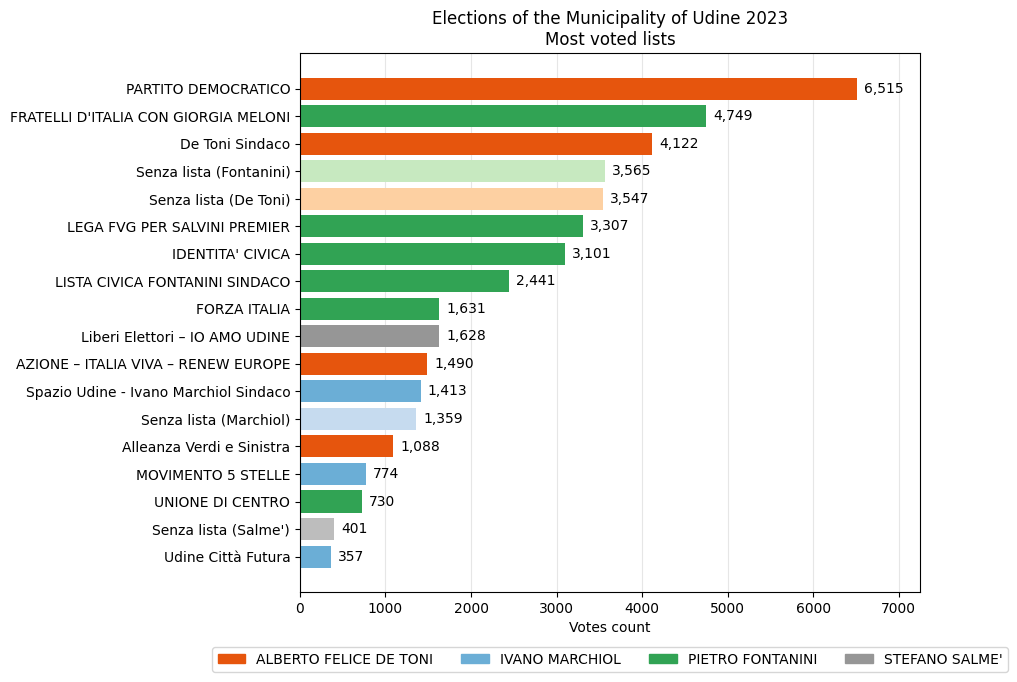

In [21]:
migliori_liste = sindaci_liste_voti.reset_index()\
    .sort_values(by='voti_validi_lista', ascending=False)\
    .reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 7))

cmap = plt.get_cmap("tab20c")

bar_container = ax.barh(
    migliori_liste.nome_lista,
    migliori_liste.voti_validi_lista,
    color=cmap([4,8,4,11,7,8,8,8,8,17,4,1,3,4,1,8,18,1]),
    zorder=2
)

ax.bar_label(bar_container, fmt='{:,.0f}', padding=5)

#plt.text(-15, 16, "Data sources: https://elezioni.regione.fvg.it/", ha='right', va='center', style='italic', size=6);

ax.invert_yaxis()

ax.set(title='Elections of the Municipality of Udine 2023\nMost voted lists')


plt.legend(
    bar_container,
    [f"{sindaci_voti.index[i][0]}" for i in range(len(sindaci_voti))],
    ncol=len(sindaci_voti.index), bbox_to_anchor=[.5, -.125], loc='center'
)

ax = plt.gca()
leg = ax.get_legend()
leg.legend_handles[0].set_color(cmap(4))
leg.legend_handles[1].set_color(cmap(1))
leg.legend_handles[2].set_color(cmap(8))
leg.legend_handles[3].set_color(cmap(17))


ax.grid(axis='x', color='0.9', zorder=-1)
ax.set_xlabel("Votes count")

plt.xlim([0,7_250])

plt.show()

In particular, the first two lists "Partito Democratico" and "Fratelli d'Italia con Giorgia Meloni" reflect the national scenario of the most popular political parties at the moment. Worth noting, the civic list supporting Alberto Felice De Toni collected more than 12% of total consents for who voted for any list, and the number of people that voted for any of the two candidates without specifying any list is almost the same for both Alberto Felice De Toni (3,547) and Pietro Fontanini (3,565).